In [1]:
import numpy as np
from tqdm import tqdm
import networkx as nx
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

In [12]:
def get_data(data):
    data = load_svmlight_file(data)
    return data[0].toarray(), data[1]
data = "./abalone_scale.txt"
X, y = get_data(data)

In [13]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.shape[0])
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [14]:
X, y = random_split(X, y, 3, 42)
X1 = X[0][:, 0:4]
X2 = X[1][:, 2: 6]
X3 = X[2][:, 3:]
y1 = y[0]
y2 = y[1]
y3 = y[2]

X_test = [np.concatenate([X[1], X[2]], axis=0), np.concatenate([X[0], X[2]], axis=0), np.concatenate([X[0], X[1]], axis=0)]
y_test = [np.concatenate((y[1], y[2])), np.concatenate((y[0], y[2])), np.concatenate((y[0], y[1]))]


subset_ranges = [np.arange(0, 4), np.arange(2, 6), np.arange(3, 8)]
subset_lengths = [subset_ranges[0].shape[0], subset_ranges[1].shape[0], subset_ranges[2].shape[0]]

X1, y1 = random_split(X1, y1, 10, 42)
X2, y2 = random_split(X2, y2, 10, 42)
X3, y3 = random_split(X3, y3, 10, 42)

In [15]:
# Graph implementation
def generate_graph(cluster_sizes=[100,100], pin=0.5, pout=0.01, seed=0):
    """Generate a random connected graph"""
    probs = np.array([[pin, pout, pout],[pout, pin, pout],[pout, pout, pin]])
    while True:
        g = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
        if nx.algorithms.components.is_connected(g):
            return g


cluster_sizes = [10, 10, 10]
pin = 0.5
pout = 0.1
seed = 0
alpha = 1e-2
lamda = 0#1e-1#1e-3#1e-1#1e-3
eta = 1 * 1e-2
d0 = min(subset_lengths)
no_users = sum(cluster_sizes)
batch_size = 20
epochs = 1
it = 500

# Set a random seed for reproducibility
seed = 17

np.random.seed(seed)
num_features = 4

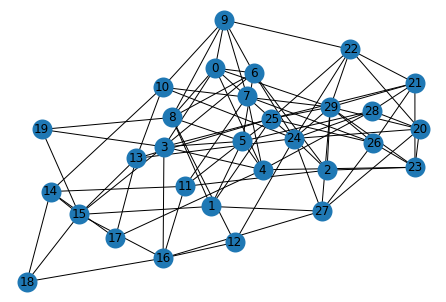

In [16]:
G = generate_graph(cluster_sizes, pin, pout, seed)
nx.draw(G, with_labels=True, node_size=100, alpha=1, linewidths=10)
plt.show()

In [17]:
def loss(w, A, b):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg


def linear_regression_loss(w, A, b):
    predictions = np.dot(A, w)
    errors = predictions - b
    mse_loss = np.mean(errors**2) / 2
    return mse_loss


def gradient(w, A, b):
    m = A.shape[0]
    bAw = b * (A @ w)
    temp = 1. / (1. + np.exp(bAw))
    res = -(A.T @ (b * temp))/m + l2 * w
    return res


def linear_regression_gradient(w, A, b):
    m = A.shape[0]
    predictions = np.dot(A, w)
    errors = predictions - b
    
    # Gradient without regularization
    gradient = np.dot(A.T, errors) / m
    
    return gradient


def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)



def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[i, :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W


adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)

print(G.number_of_edges())
print(G.number_of_nodes())

90
30


In [18]:
theta = [np.zeros(num_features) for _ in range(no_users)]

In [37]:
n_iters = 200
alpha = 0.01

losses_dsgd = []

theta0 = np.zeros(num_features)
op_gap_dsgd = np.zeros(shape=[n_iters])


for k in range(n_iters):       
    print(theta[0].shape, X1[0].shape, y1[0].shape)
    
    grad = linear_regression_gradient(theta[0], X1[0], y1[0])
    
    theta[0] = theta[0] - alpha*grad
    acc = np.mean(np.abs(np.dot(X1[0], theta[0]) - y1[0]) < 3.)
  

    loss_dsgd = linear_regression_loss(theta[0], X1[0], y1[0])
    losses_dsgd.append(loss_dsgd)
    print("%d:   Loss:   %2.6f,     Acc:    %2.6f"%(k, losses_dsgd[-1], acc))


(4,) (140, 4) (140,)
0:   Loss:   4.297401,     Acc:    0.771429
(4,) (140, 4) (140,)
1:   Loss:   4.297398,     Acc:    0.771429
(4,) (140, 4) (140,)
2:   Loss:   4.297396,     Acc:    0.771429
(4,) (140, 4) (140,)
3:   Loss:   4.297394,     Acc:    0.771429
(4,) (140, 4) (140,)
4:   Loss:   4.297392,     Acc:    0.771429
(4,) (140, 4) (140,)
5:   Loss:   4.297390,     Acc:    0.771429
(4,) (140, 4) (140,)
6:   Loss:   4.297388,     Acc:    0.771429
(4,) (140, 4) (140,)
7:   Loss:   4.297386,     Acc:    0.771429
(4,) (140, 4) (140,)
8:   Loss:   4.297384,     Acc:    0.771429
(4,) (140, 4) (140,)
9:   Loss:   4.297382,     Acc:    0.771429
(4,) (140, 4) (140,)
10:   Loss:   4.297380,     Acc:    0.771429
(4,) (140, 4) (140,)
11:   Loss:   4.297378,     Acc:    0.771429
(4,) (140, 4) (140,)
12:   Loss:   4.297376,     Acc:    0.771429
(4,) (140, 4) (140,)
13:   Loss:   4.297375,     Acc:    0.771429
(4,) (140, 4) (140,)
14:   Loss:   4.297373,     Acc:    0.771429
(4,) (140, 4) (140,)

In [11]:
theta[0], X1[0], y1[0]

array([20.,  9.,  8., ..., 12., 10., 14.])

0.8357142857142857

In [24]:
y1[0]

array([ 9.,  6., 11.,  9.,  9., 19., 13.,  7.,  8.,  7.,  8., 14., 11.,
       15., 12.,  9., 10.,  8.,  4., 12.,  5., 17., 15., 11., 17., 12.,
        6.,  9., 11., 11.,  8.,  8.,  8., 15.,  5.,  8.,  9., 11.,  9.,
        9., 10., 13.,  9.,  8.,  4., 11.,  7.,  7.,  9.,  8.,  6.,  4.,
       10., 10.,  6.,  7., 14., 21.,  8., 18., 10.,  8., 11., 10.,  7.,
       11.,  9., 17.,  7., 13., 15., 10., 12., 18.,  8., 10.,  5., 11.,
        6.,  8., 20., 15.,  5.,  8., 10., 10., 11.,  8.,  9.,  9., 11.,
       13.,  5.,  9.,  9.,  8., 20.,  9.,  4., 11., 11., 13.,  7.,  7.,
       12.,  9.,  9.,  7., 13.,  9., 11., 10.,  9.,  3.,  9., 12.,  8.,
        8.,  8., 11.,  9., 10., 13., 10., 15., 10.,  9., 13., 11.,  8.,
        9.,  9.,  9.,  6., 10., 10.,  5., 19.,  6., 10.])

In [42]:
np.dot(X1[0], theta[0])

array([11.86570113,  7.21163254, 11.64487075, 11.12852578,  9.9509929 ,
       10.92902416, 10.05207379,  7.19590048, 11.11817124,  7.47316386,
        7.02921058,  8.45791743, 11.09745452, 11.5531985 , 12.43312814,
        8.14300198, 12.22700193,  9.91161219,  4.90962065,  8.56266013,
        5.61514274, 11.15720816,  9.24313124, 10.70455672,  9.6547833 ,
       10.45837089,  6.60285244,  9.11103815, 11.40536838, 11.96543448,
        8.01389923,  9.05696766, 11.82734549, 10.84394909,  5.99105251,
       10.91200126, 12.54248061, 11.51482259, 10.88397988, 12.90076902,
       11.40339399, 10.85126869, 11.61752335,  8.49557813,  3.63971186,
        9.73948124,  7.00014637,  6.0598337 , 10.83960922,  7.89646413,
        6.379046  ,  5.18147647, 12.56992975, 11.4077085 ,  8.1016175 ,
        8.05158747, 10.49302159, 10.94004885, 10.7872568 , 13.57658085,
       11.83903118, 10.17309505, 12.80605038, 13.08456344,  8.14769193,
       11.0244753 , 10.6504814 , 10.46871677, 10.34155514, 10.36